In [1]:
import os
os.chdir('/home/sebastiaan/PhD/Repositories/immune_response_detection/')

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pwseqdist as pw

from scipy.spatial.distance import pdist, squareform

from tcrdist.rep_funcs import _pws, _pw
from tcrdist.repertoire import TCRrep

from raptcr.constants.preprocessing import add_cdr_columns, to_tcrdist3_format
from raptcr.constants.hashing import TCRDIST_DM
from raptcr.hashing import Cdr3Hasher

from tcrdist.rep_funcs import _pws

In [78]:
df = pd.read_csv('./data/phil/pregibon_tcrs.tsv', sep='\t')
df = df[['cdr3b','vb','jb']]
df = add_cdr_columns(df, vcol='vb')
df = to_tcrdist3_format(df, vgenecol='vb', jgenecol='jb', cdr3col='cdr3b')
df = df.drop_duplicates()
print(df.shape, df.head())

(786, 5)           cdr3_b_aa     v_b_gene    j_b_gene cdr1_b_aa cdr2_b_aa
0    CAISESNDGNEQFF  TRBV10-3*01  TRBJ2-1*01     ENHRY    SYGVKD
1   CASTLGTSHDYEQYF   TRBV7-6*01  TRBJ2-7*01     SGHVS    FNYEAQ
2    CAISESLGQDQQYF  TRBV10-3*01  TRBJ2-7*01     ENHRY    SYGVKD
3  CAISESRSSGADTQYF  TRBV10-3*01  TRBJ2-3*01     ENHRY    SYGVKD
4   CAISESTGLRDEQFF  TRBV10-3*01  TRBJ2-1*01     ENHRY    SYGVKD


In [68]:
def tcrdistance_matrix(df, gp:int=3, ntrim=3, ctrim=2, ncpus=1):

    # Choose the metrics you want to apply to each CDR
    metrics = {'cdr3_b_aa' : pw.metrics.nb_vector_tcrdist,
               'cdr2_b_aa' : pw.metrics.nb_vector_tcrdist,
               'cdr1_b_aa' : pw.metrics.nb_vector_tcrdist}

    # CDR weights
    weights = {'cdr3_b_aa' : 3, 'cdr2_b_aa' : 1, 'cdr1_b_aa' : 1}

    # Provide arguments for the distance metrics 
    kargs = {'cdr3_b_aa' : {'use_numba': True, 'distance_matrix': pw.matrices.tcr_nb_distance_matrix, 'dist_weight': 1, 'gap_penalty':gp, 'ntrim':ntrim, 'ctrim':ctrim, 'fixed_gappos':False},
             'cdr2_b_aa' : {'use_numba': True, 'distance_matrix': pw.matrices.tcr_nb_distance_matrix, 'dist_weight': 1, 'gap_penalty':gp, 'ntrim':0, 'ctrim':0, 'fixed_gappos':True},
             'cdr1_b_aa' : {'use_numba': True, 'distance_matrix': pw.matrices.tcr_nb_distance_matrix, 'dist_weight': 1, 'gap_penalty':gp, 'ntrim':0, 'ctrim':0, 'fixed_gappos':True}}

    # Build distance matrix            
    dmats = _pws(
        df = df,
        metrics = metrics,
        weights= weights,
        kargs=kargs,
        cpu = ncpus, 
        store = True
        )

    return dmats['tcrdist']

In [69]:
from raptcr.constants.hashing import DEFAULT_DM # RapTCR BLOSUM matrix
from raptcr.constants.hashing import TCRDIST_DM # Square-rooted TCRDist matrix 

def multidim_hashing(df, dm=DEFAULT_DM, dims=None, weigh_cdr3=False):
    # Default configation
    if dims is None:
        dims = [
        [4,4,8],
        [8,8,16],
        [16,16,32],
        [32,32,64],
        [64,64,128]
        ]
    # Store results in dict
    res = {}
    # Iterate over different configurations
    for n,d in enumerate(dims):
        print(f'Configuration {n}')
        # Configure hashers for each CDR
        cdr1hasher = Cdr3Hasher(m=d[0], distance_matrix=dm).fit()
        cdr2hasher = Cdr3Hasher(m=d[1], distance_matrix=dm).fit()
        cdr3hasher = Cdr3Hasher(m=d[2], distance_matrix=dm).fit()
        # Generate embeddings
        df['Y_cdr1'] = list(cdr1hasher.fit_transform(df.cdr1_b_aa.tolist()))
        df['Y_cdr2'] = list(cdr2hasher.fit_transform(df.cdr2_b_aa.tolist()))
        df['Y_cdr3'] = list(cdr3hasher.fit_transform(df.cdr3_b_aa.tolist()))
        if weigh_cdr3:
            from raptcr.constants.distributions import gaussian_vector
            w = gaussian_vector(nbins=d[2]) # weights vector
            df['Y_cdr3'] = df['Y_cdr3'].apply(lambda x: x * w)
        # Join individual embeddings into one vector
        embeddings = ['Y_cdr1', 'Y_cdr2', 'Y_cdr3']
        df['Y_tcr'] = df[embeddings].apply(lambda x: np.concatenate((x[0], x[1], x[2])), axis=1)
        # Compute L2 distances between vectors
        res[f'L2_config_{n}'] = pdist(X=df.Y_tcr.to_list(), metric='euclidean')
    return pd.DataFrame(res)

In [71]:
tcrdistances = squareform(tcrdistance_matrix(df, ncpus=8))

distances_BLOSUM = multidim_hashing(df, dm=DEFAULT_DM)
distances_BLOSUM['TCRDist'] = tcrdistances

distances_TCRDIST = multidim_hashing(df, dm=TCRDIST_DM)
distances_TCRDIST['TCRDist'] = tcrdistances

Configuration 0
Configuration 1
Configuration 2
Configuration 3
Configuration 4
Configuration 0
Configuration 1
Configuration 2
Configuration 3
Configuration 4


In [57]:
from scipy.stats import linregress

def rsquared(x, y):
    slope, intercept, r, p, std_err = linregress(x=x, y=y)
    return np.round(r**2,3), p

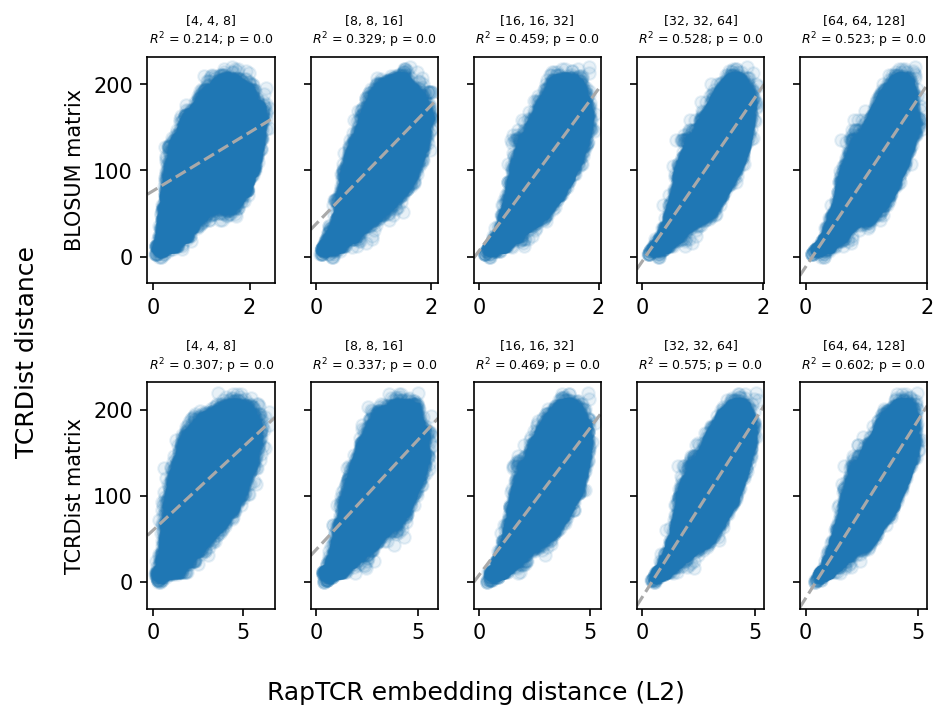

In [77]:
# Configurations tested
configurations = [[4,4,8],[8,8,16],[16,16,32],[32,32,64],[64,64,128]]

# Plot results 
fig, ax = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=False, sharey=True)

# BLOSUM matrix
y = distances_BLOSUM['TCRDist']
ax[0,0].set_ylabel('BLOSUM matrix')
for n,config in enumerate(configurations):
    x = distances_BLOSUM[f'L2_config_{n}']
    slope, intercept, r, p, std_err = linregress(x=x, y=y)
    ax[0,n].scatter(
        x = x,
        y = y,
        alpha = .1
    )
    ax[0,n].axline(xy1=(0,intercept), slope=slope, ls='--', c='darkgrey')
    ax[0,n].set_title(f'{str(config)}\n$R^{2}$ = {np.round(r**2,3)}; p = {p}', fontsize=6)

# TCRDist matrix (square-rooted)
y = distances_TCRDIST['TCRDist']
ax[1,0].set_ylabel('TCRDist matrix')
for n,config in enumerate(configurations):
    x = distances_TCRDIST[f'L2_config_{n}']
    slope, intercept, r, p, std_err = linregress(x=x, y=y)
    ax[1,n].scatter(
        x = x,
        y = y,
        alpha = .1
    )
    ax[1,n].axline(xy1=(0,intercept), slope=slope, ls='--', c='darkgrey')
    ax[1,n].set_title(f'{str(config)}\n$R^{2}$ = {np.round(r**2,3)}; p = {p}', fontsize=6)

fig.supxlabel('RapTCR embedding distance (L2)')
fig.supylabel('TCRDist distance')

fig.tight_layout()
fig.savefig('./fig/raptcr_vs_tcrdist_pregibon.png', dpi=300, format='png')
# fig.savefig('./fig/raptcr_vs_tcrdist_pregibon.pdf', dpi=300, format='pdf')